### Packages utlisés

In [ ]:
import pandas as pd
import re
import string
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import bigrams
import spacy
from itertools import combinations
import json

import spacy
import spacy.cli

from pathlib import Path

import torch
from transformers import (
    TextClassificationPipeline, 
    AutoModelForSequenceClassification, 
    AutoTokenizer
)

c:\Users\kadas\Desktop\Mes_cours\FINANCE_QUAN\Projet_finance_quantitative\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optionnel pour WordNet Lemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kadas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kadas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kadas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kadas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Chargement des données 

In [5]:
# Dossier principal pour les données
DATA_DIR = Path.cwd().parent / "data"
ARTICLES_DIR = DATA_DIR / "raw"

# Liste des cryptomonnaies à analyser
cryptos = [
    "binance_coin", "bitcoin", "cardano", "dogecoin", "ethereum",
    "solana", "tether", "xrp", "litecoin", "shiba_inu", "tron"
]

# Boucle pour charger les fichiers d'articles et de posts
for crypto in cryptos:
    try:
        # Chemins des fichiers CSV pour chaque cryptomonnaie
        articles_path = ARTICLES_DIR / f"articles_{crypto}.csv"

        # Chargement des fichiers dans des DataFrames pandas
        articles = pd.read_csv(articles_path)

        # Informations sur la taille des fichiers
        print(f"{crypto.capitalize()} : Articles ({articles.shape[0]} lignes, {articles.shape[1]} colonnes)")
    except FileNotFoundError as e:
        # Message d'alerte en cas de fichier manquant
        print(f"⚠️ Fichier introuvable pour {crypto} : {e}")

Binance_coin : Articles (1189 lignes, 3 colonnes)
Bitcoin : Articles (1049 lignes, 3 colonnes)
Cardano : Articles (902 lignes, 3 colonnes)
Dogecoin : Articles (1363 lignes, 3 colonnes)
Ethereum : Articles (3054 lignes, 3 colonnes)
Solana : Articles (2672 lignes, 3 colonnes)
Tether : Articles (529 lignes, 3 colonnes)
Xrp : Articles (1653 lignes, 3 colonnes)
Litecoin : Articles (138 lignes, 3 colonnes)
Shiba_inu : Articles (1168 lignes, 3 colonnes)
Tron : Articles (3032 lignes, 3 colonnes)


#### Vérification des news sans date renseignée

In [6]:
# Dictionnaire pour stocker les DataFrames des cryptomonnaies
crypto_dfs = {}

# Boucle pour charger les fichiers et vérifier les news sans date renseignée
for crypto in cryptos:
    try:
        articles_path = ARTICLES_DIR / f"articles_{crypto}.csv"

        articles = pd.read_csv(articles_path)
        crypto_dfs[crypto] = articles

        # Vérification des lignes sans date renseignée
        missing_date_count = articles["date"].eq("Inconnu").sum()

        print(f"{crypto.capitalize()} : {missing_date_count} lignes avec 'Inconnu'")
    except FileNotFoundError as e:
        print(f"⚠️ Fichier introuvable pour {crypto} : {e}")

Binance_coin : 28 lignes avec 'Inconnu'
Bitcoin : 24 lignes avec 'Inconnu'
Cardano : 8 lignes avec 'Inconnu'
Dogecoin : 13 lignes avec 'Inconnu'
Ethereum : 8 lignes avec 'Inconnu'
Solana : 14 lignes avec 'Inconnu'
Tether : 13 lignes avec 'Inconnu'
Xrp : 10 lignes avec 'Inconnu'
Litecoin : 15 lignes avec 'Inconnu'
Shiba_inu : 5 lignes avec 'Inconnu'
Tron : 1 lignes avec 'Inconnu'


#### Fusion des bases de données sur les différentes cryptomonnaies

In [7]:
# Fusionner toutes les bases de données des cryptomonnaies dans un seul DataFrame
def merge_crypto_dfs(crypto_dfs):
    """
    Fusionne les DataFrames des différentes cryptomonnaies en un seul DataFrame.

    Args:
        crypto_dfs (dict): Dictionnaire contenant les DataFrames des cryptomonnaies.

    Returns:
        pd.DataFrame: DataFrame fusionné contenant les données de toutes les cryptomonnaies.
    """
    return pd.concat(crypto_dfs.values(), ignore_index=True)

# Fusion des données
df_crypto = merge_crypto_dfs(crypto_dfs)

# Vérification de la fusion
print(f"Fusion réussie : Nombre total de lignes : {df_crypto.shape[0]}")
print(f"Aperçu des colonnes du DataFrame fusionné : {df_crypto.columns}")
print(df_crypto.tail())

Fusion réussie : Nombre total de lignes : 16749
Aperçu des colonnes du DataFrame fusionné : Index(['title', 'date', 'description'], dtype='object')
                                                   title                 date  \
16744  Traders predict Mog Coin, Dogwifhat to be next...  2024-10-10 18:54:00   
16745  3 low cap crypto gems that could soar this winter  2024-10-10 18:12:00   
16746  SOL fights to reclaim $160 as this $0.03 altco...  2024-10-10 18:00:00   
16747  SEC sues Cumberland DRW for operating as unreg...  2024-10-10 17:59:00   
16748  From $1,500 to a yacht: 3 RWA coins under $0.4...  2024-10-10 17:40:00   

                                             description  
16744  Mog Coin and Dogwifhat have surged this year, ...  
16745  As winter approaches, investors are seeking lo...  
16746  Can Solana regain its momentum to hit the $160...  
16747  The U.S. Securities and Exchange Commission ha...  
16748  Investing in RWA coins under $0.30 could yield...  


#### Suppresion de certaines lignes (valeurs manquantes) 

In [8]:
# Suppression des lignes inutiles ou avec des valeurs manquantes
def clean_dataframe(df):
    """
    Nettoie un DataFrame en supprimant les lignes avec des valeurs manquantes ou non pertinentes.

    Args:
        df (pd.DataFrame): DataFrame à nettoyer.

    Returns:
        pd.DataFrame: DataFrame nettoyé avec l'index réinitialisé.
    """
    # Supprimer les lignes où 'date' est "Inconnu" ou contient des NaN
    df = df[~df["date"].astype(str).str.lower().eq("inconnu")]

    # Supprimer les lignes où 'description' est vide ou contient uniquement des espaces
    df = df.dropna(subset=["description"])
    df = df[df["description"].str.strip() != ""]

    # Réinitialisation de l'index après suppression
    return df.reset_index(drop=True)

# Nettoyage du DataFrame fusionné
df_crypto = clean_dataframe(df_crypto)

print(f"Nettoyage terminé : Nombre de lignes restantes : {df_crypto.shape[0]}")
print(f"Colonnes disponibles : {df_crypto.columns}")
print(df_crypto.tail())

Nettoyage terminé : Nombre de lignes restantes : 16610
Colonnes disponibles : Index(['title', 'date', 'description'], dtype='object')
                                                   title                 date  \
16605  Traders predict Mog Coin, Dogwifhat to be next...  2024-10-10 18:54:00   
16606  3 low cap crypto gems that could soar this winter  2024-10-10 18:12:00   
16607  SOL fights to reclaim $160 as this $0.03 altco...  2024-10-10 18:00:00   
16608  SEC sues Cumberland DRW for operating as unreg...  2024-10-10 17:59:00   
16609  From $1,500 to a yacht: 3 RWA coins under $0.4...  2024-10-10 17:40:00   

                                             description  
16605  Mog Coin and Dogwifhat have surged this year, ...  
16606  As winter approaches, investors are seeking lo...  
16607  Can Solana regain its momentum to hit the $160...  
16608  The U.S. Securities and Exchange Commission ha...  
16609  Investing in RWA coins under $0.30 could yield...  


#### Création de la colonne "cryptocurrency"

In [9]:
# Un dictionnaire pour mapper les noms des cryptos avec leurs abréviations officielles
crypto_mapping = {
    "Bitcoin": "BTC",
    "Ethereum": "ETH",
    "BNB": "BNB",
    "Solana": "SOL",
    "Cardano": "ADA",
    "Dogecoin": "DOGE",
    "Shiba_inu": "SHIB",
    "Litecoin": "LTC",
    "Tether": "USDT",
    "XRP": "XRP",
    "Tron": "TRX"
}

# Fonction pour détecter une crypto dans une chaîne de texte
def find_primary_crypto(text):
    # Vérification si le texte est NaN ou non
    if pd.isna(text):
        return None

    # Conversion du texte en string pour éviter les erreurs
    text = str(text)

    # Recherche de correspondances dans le texte en utilisant les clés du mapping
    for key, value in crypto_mapping.items():
        pattern = rf"\b{re.escape(key)}\b"  # Recherche du mot complet (sensibilité à l'espacement)
        if re.search(pattern, text, re.IGNORECASE):  # Recherche insensible à la casse
            return value  

    # Retourne None si aucune correspondance n'est trouvée
    return None

# Fonction principale : recherche dans la description, puis dans le titre si nécessaire
def detect_crypto(row):
    # Recherche prioritairement dans la description
    primary_crypto = find_primary_crypto(row["description"])

    # Si aucune crypto trouvée, recherche dans le titre
    if primary_crypto is None:
        primary_crypto = find_primary_crypto(row["title"])

    # Retourne le nom de la crypto trouvé ou None
    return primary_crypto

# Création de la colonne "cryptocurrency" en appliquant la fonction sur chaque ligne
df_crypto["cryptocurrency"] = df_crypto.apply(detect_crypto, axis=1)

In [10]:
df_crypto.head(5)

,title,date,description,cryptocurrency
0,Binance coin’s strong year falters as 1Fuel dr...,2025-02-05 13:47:00,Binance coin drops 17% in a month as investors...,XRP
1,"Cryptos to watch in 2025: Rollblock, Cardano, ...",2025-01-23 20:55:00,Not all fast-growing crypto tokens are good in...,ADA
2,"Remittix could outperform Shiba Inu, Cardano a...",2025-01-23 13:02:00,Remittix is making waves in the crypto industr...,ADA
3,Binance Coin drops despite flipping Ethereum i...,2025-01-20 17:45:00,Binance Coin price remained in a tight range o...,ETH
4,Why this crypto could outshine Binance Coin an...,2025-01-16 09:50:00,As the crypto market gears up for its next bul...,XRP


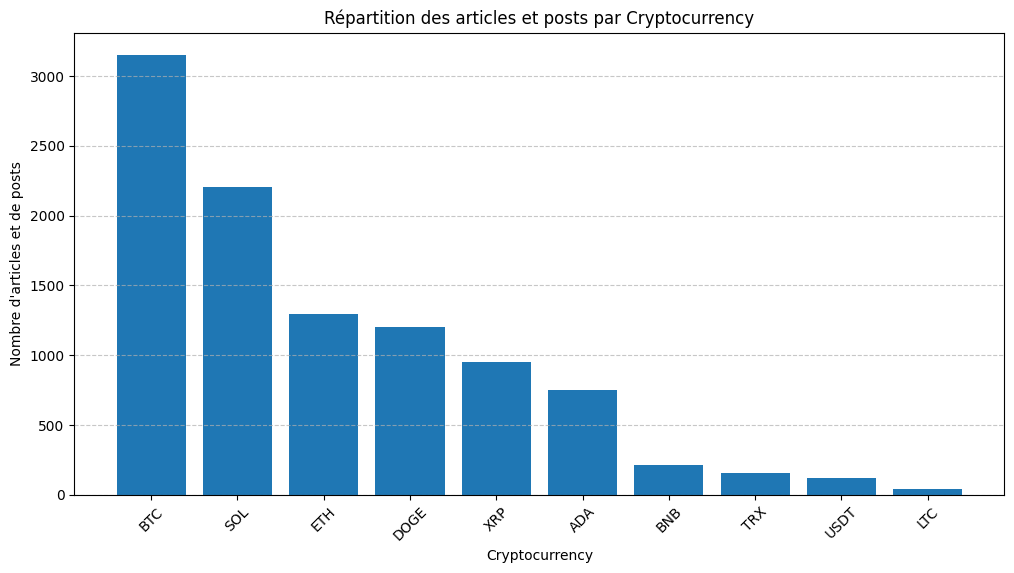

In [11]:
# Le comptage des occurrences de chaque crypto pour analyser leur répartition
crypto_counts = df_crypto["cryptocurrency"].value_counts()

plt.figure(figsize=(12, 6))  
plt.bar(crypto_counts.index, crypto_counts.values) 
plt.xlabel("Cryptocurrency")  
plt.ylabel("Nombre d'articles et de posts")  
plt.title("Répartition des articles et posts par Cryptocurrency")  
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)  

plt.show()

### Preprocessing des données textuelles

In [12]:
# Une installation et un chargement du modèle Spacy pour le traitement de texte en anglais
spacy.cli.download("en_core_web_sm") 
nlp = spacy.load("en_core_web_sm")  # Charger le modèle pour l'analyse linguistique

# Une liste personnalisée de mots à ignorer, incluant des termes spécifiques au contexte crypto
custom_stop_words = [
    "http", "https", "www", "coin", "crypto", "cryptocurrency", "bitcoin", "btc",
    "ethereum", "eth", "blockchain", "today", "tonight", "actually", "lol",
    "day", "hour", "minute", "sec", "talk", "price", "market", "coin"
]

# Une fonction dédiée au nettoyage et au prétraitement des textes
def crypto_text_preprocessing(text):
    # Les URL, mentions et hashtags sont supprimés pour réduire le bruit dans les données
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[@#]\w+', '', text)

    # Les balises HTML, souvent inutiles, sont également supprimées
    text = re.sub(r'<.*?>', '', text)

    # On se concentre uniquement sur les caractères alphanumériques
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    text = text.lower()  # Une conversion en minuscules pour uniformiser le texte

    # Une tokenisation avec Spacy pour segmenter le texte en mots
    doc = nlp(text)
    tokens = [
        token.text for token in doc
        if not token.is_stop  # Exclusion les mots vides identifiés par Spacy
        and token.text not in custom_stop_words  # On ignore les mots personnalisés inutiles
        and len(token.text) > 2  # On élimine les mots trop courts
        and token.is_alpha  # Et l'on conserve uniquement les mots composés de lettres
    ]

    # Les bigrammes (paires de mots consécutifs) sont générés pour enrichir l'analyse
    bigram_list = [
        "_".join(bigram) for bigram in combinations(tokens, 2)
        if bigram[0] not in tokens or bigram[1] not in tokens
    ]

    # Le texte nettoyé est reconstruit en combinant tokens et bigrammes
    text_cleaned = " ".join(tokens + bigram_list)

    return text_cleaned

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Application de la fonction de preprocessing 

In [13]:
# Élimination des lignes avec des valeurs manquantes dans la colonne "description"
df_crypto = df_crypto.dropna(subset=["description"])

# Création d'une nouvelle colonne avec le texte nettoyé
df_crypto["cleaned_description"] = df_crypto["description"].apply(crypto_text_preprocessing)

df_crypto[["description", "cleaned_description"]].head()

,description,cleaned_description
0,Binance coin drops 17% in a month as investors...,binance drops month investors turn rising gain...
1,Not all fast-growing crypto tokens are good in...,fastgrowing tokens good investments rollblock ...
2,Remittix is making waves in the crypto industr...,remittix making waves industry smart approach ...
3,Binance Coin price remained in a tight range o...,binance remained tight range monday network su...
4,As the crypto market gears up for its next bul...,gears bull run lightchain emerging potential g...


In [14]:
df_crypto

,title,date,description,cryptocurrency,cleaned_description
0,Binance coin’s strong year falters as 1Fuel dr...,2025-02-05 13:47:00,Binance coin drops 17% in a month as investors...,XRP,binance drops month investors turn rising gain...
1,"Cryptos to watch in 2025: Rollblock, Cardano, ...",2025-01-23 20:55:00,Not all fast-growing crypto tokens are good in...,ADA,fastgrowing tokens good investments rollblock ...
2,"Remittix could outperform Shiba Inu, Cardano a...",2025-01-23 13:02:00,Remittix is making waves in the crypto industr...,ADA,remittix making waves industry smart approach ...
3,Binance Coin drops despite flipping Ethereum i...,2025-01-20 17:45:00,Binance Coin price remained in a tight range o...,ETH,binance remained tight range monday network su...
4,Why this crypto could outshine Binance Coin an...,2025-01-16 09:50:00,As the crypto market gears up for its next bul...,XRP,gears bull run lightchain emerging potential g...
...,...,...,...,...,...
16605,"Traders predict Mog Coin, Dogwifhat to be next...",2024-10-10 18:54:00,"Mog Coin and Dogwifhat have surged this year, ...",None,mog dogwifhat surged year ansem murad predicti...
16606,3 low cap crypto gems that could soar this winter,2024-10-10 18:12:00,"As winter approaches, investors are seeking lo...",None,winter approaches investors seeking lowcap gem...
16607,SOL fights to reclaim $160 as this $0.03 altco...,2024-10-10 18:00:00,Can Solana regain its momentum to hit the $160...,SOL,solana regain momentum hit mark overshadowed p...
16608,SEC sues Cumberland DRW for operating as unreg...,2024-10-10 17:59:00,The U.S. Securities and Exchange Commission ha...,None,securities exchange commission filed charges c...


#### Modèle CryptoBERT

In [15]:
# Vérification de la version de Torch et de la disponibilité du GPU
print("Torch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())

# Spécification du modèle pré-entraîné CryptoBERT
model_name = "ElKulako/cryptobert"

# Chargement du tokenizer pour convertir le texte en tokens
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# Chargement du modèle pour la classification des sentiments (3 classes)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Configuration du pipeline pour combiner modèle et tokenizer
pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    max_length=128,  
    truncation=True,  
    padding="max_length" 
)

print("Model loaded successfully!")

Torch version: 2.6.0+cpu
GPU available: False


Device set to use cpu


Model loaded successfully!


#### Création du modèle

In [16]:
# Spécifier le modèle pré-entraîné CryptoBERT
model_name = "ElKulako/cryptobert"

# Charger le tokenizer pour convertir le texte brut en tokens
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# Charger le modèle pré-entraîné pour la classification des sentiments (3 classes)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Configurer le pipeline combinant le modèle et le tokenizer
pipe = TextClassificationPipeline(
    model=model,           # Modèle CryptoBERT
    tokenizer=tokenizer,   # Tokenizer associé
    max_length=128,        # Limite de longueur des séquences
    truncation=True,       # Tronquer les séquences longues
    padding='max_length'   # Ajouter du padding pour uniformiser la longueur
)

Device set to use cpu


#### Classification des news selon le sentiment (positif, neutre, négatif)

In [17]:
def classify_sentiment(text):
    """
    Fonction qui détermine le sentiment d'un texte à l'aide de CryptoBERT.
    Retourne un label et un score associés.
    """
    if pd.isna(text) or not isinstance(text, str) or text.strip() == "":
        # Cas où le texte est vide ou invalide
        return {"label": "Unknown", "score": 0.0}

    # Prédiction du sentiment à l'aide du modèle
    prediction = pipe(text)[0]
    return {"label": prediction["label"], "score": prediction["score"]}

# Application de la fonction pour classifier les descriptions nettoyées
df_crypto["sentiment"] = df_crypto["cleaned_description"].apply(classify_sentiment)

# Extraction des résultats dans des colonnes séparées
df_crypto["sentiment_label"] = df_crypto["sentiment"].apply(lambda x: x["label"])
df_crypto["sentiment_score"] = df_crypto["sentiment"].apply(lambda x: x["score"])

In [18]:
df_crypto.columns

Index(['title', 'date', 'description', 'cryptocurrency', 'cleaned_description',
       'sentiment', 'sentiment_label', 'sentiment_score'],
      dtype='object')

In [19]:
# Distribution des pourcentages pour chaque type de sentiment
if "sentiment_label" in df_crypto.columns:
    sentiment_counts = df_crypto["sentiment_label"].value_counts(normalize=True) * 100

    sentiment_percentages = sentiment_counts.reset_index()
    sentiment_percentages.columns = ["Sentiment", "Percentage"]
    print(sentiment_percentages)
else:
    print("⚠️ La colonne 'sentiment_label' est absente. Vérifiez que la classification a bien été effectuée.")

  Sentiment  Percentage
0   Neutral   68.946418
1   Bullish   30.258880
2   Bearish    0.794702


#### Décomposer la date en deux nouvelles variables 



In [20]:
def split_datetime(df, date_column="date"):
    """
    Fonction pour séparer une colonne datetime en deux colonnes distinctes :
    - Une colonne pour la date uniquement.
    - Une colonne pour l'heure uniquement.
    """
    # Conversion des valeurs en format datetime pour éviter les erreurs
    df[date_column] = pd.to_datetime(df[date_column], errors="coerce")

    # Création de colonnes séparées pour la date et l'heure
    df["date_only"] = df[date_column].dt.date  # Contenu limité à la date
    df["time_only"] = df[date_column].dt.time  # Contenu limité à l'heure

    return df

# Ajout des colonnes "date_only" et "time_only" au DataFrame
df_crypto = split_datetime(df_crypto, date_column="date")

In [21]:
df_crypto = split_datetime(df_crypto,date_column="date")

In [23]:
def encode_sentiment(df):
    """
    Ajoute une colonne 'sentiment_coded' avec des valeurs numériques basées sur 'sentiment_label'.
    - 'Bullish'  → +1
    - 'Neutral'  →  0
    - 'Bearish'  → -1
    """
    # Les correspondances entre les labels de sentiment et leurs valeurs numériques
    sentiment_mapping = {"Bullish": 1, "Neutral": 0, "Bearish": -1}

    # Ajout d'une nouvelle colonne pour stocker les valeurs numériques des sentiments
    df["sentiment_coded"] = df["sentiment_label"].map(sentiment_mapping)

    return df

In [24]:
# Ajout de la colonne 'sentiment_coded' dans le DataFrame
df_crypto = encode_sentiment(df_crypto)

In [25]:
def compute_sentiment_features(df_news):
    """
    Calcule les story-level sentiments et company-level sentiments (daily sentiment).

    Args:
        df_news (pd.DataFrame): DataFrame contenant :
            - 'date_only' : Date de la news.
            - 'cryptocurrency' : Crypto concernée.
            - 'sentiment_score' : Confiance du sentiment (0 à 1).
            - 'sentiment_label' : Label du sentiment ("Bullish", "Neutral", "Bearish").

    Returns:
        pd.DataFrame: DataFrame avec les colonnes sentiment_daily (company-level sentiment).
    """
    # Vérification de la présence des colonnes nécessaires pour le calcul
    required_columns = ["date_only", "cryptocurrency", "sentiment_score", "sentiment_label"]
    for col in required_columns:
        if col not in df_news.columns:
            raise KeyError(f"La colonne '{col}' est manquante dans le DataFrame.")

    # Ajout de colonnes pour les sentiments pondérés
    sentiment_mapping = {"Bullish": 1, "Neutral": 0, "Bearish": -1}
    df_news["sentiment_coded"] = df_news["sentiment_label"].map(sentiment_mapping)
    df_news["story_level_sentiment"] = df_news["sentiment_coded"] * df_news["sentiment_score"]

    # Calcul des sentiments agrégés par date et cryptomonnaie
    df_daily = (
        df_news.groupby(["date_only", "cryptocurrency"])
        .apply(
            lambda x: x["story_level_sentiment"].sum() / x["sentiment_score"].sum()
            if x["sentiment_score"].sum() != 0 else 0
        )
        .reset_index(name="sentiment_daily")
    )

    return df_daily

# Filtrage des données pour conserver uniquement les lignes avec des cryptos valides
df_crypto = df_crypto[df_crypto["cryptocurrency"].notna() & (df_crypto["cryptocurrency"] != "None")]

# Calcul des sentiments au niveau journalier
df_daily = compute_sentiment_features(df_crypto)

C:\Users\kadas\AppData\Local\Temp\ipykernel_20604\2107701385.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news["sentiment_coded"] = df_news["sentiment_label"].map(sentiment_mapping)
C:\Users\kadas\AppData\Local\Temp\ipykernel_20604\2107701385.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news["story_level_sentiment"] = df_news["sentiment_coded"] * df_news["sentiment_score"]
C:\Users\kadas\AppData\Local\Temp\ipykernel_20604\2107701385.py:29: DeprecationWarning: DataFrameGroupBy.apply ope

In [27]:
print(df_daily.head(25))
print(df_daily.shape)

     date_only cryptocurrency  sentiment_daily
0   2024-08-13            BTC         0.196341
1   2024-08-13           DOGE         0.000000
2   2024-08-13            SOL         0.000000
3   2024-08-13           USDT         0.444691
4   2024-08-14            ADA         0.000000
5   2024-08-14            BTC         0.249238
6   2024-08-14           DOGE         0.000000
7   2024-08-14            ETH         0.241085
8   2024-08-14            SOL         0.000000
9   2024-08-14           USDT         1.000000
10  2024-08-15            BTC         0.098592
11  2024-08-15            ETH         0.750418
12  2024-08-15            SOL         0.000000
13  2024-08-15            TRX         1.000000
14  2024-08-16            ADA         0.000000
15  2024-08-16            BTC         0.218831
16  2024-08-16            ETH         0.000000
17  2024-08-16            SOL         0.000000
18  2024-08-17            BTC         0.485785
19  2024-08-18            ADA         0.000000
20  2024-08-1

In [28]:
print("Type de 'date_only' dans df_daily :", df_daily['date_only'].dtype)
print("Type de 'date_only' dans df_crypto :", df_crypto['date_only'].dtype)

Type de 'date_only' dans df_daily : object
Type de 'date_only' dans df_crypto : object


In [29]:
# Conversion de la colonne 'date_only' en format datetime
df_crypto['date_only'] = pd.to_datetime(df_crypto['date_only'], errors='coerce')
df_daily['date_only'] = pd.to_datetime(df_daily['date_only'], errors='coerce')

C:\Users\kadas\AppData\Local\Temp\ipykernel_20604\494472637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crypto['date_only'] = pd.to_datetime(df_crypto['date_only'], errors='coerce')


In [30]:
df_daily = df_daily[df_daily['date_only'] >= '2024-08-13']

In [31]:
print(df_daily.head(25))
print(df_daily.shape)

    date_only cryptocurrency  sentiment_daily
0  2024-08-13            BTC         0.196341
1  2024-08-13           DOGE         0.000000
2  2024-08-13            SOL         0.000000
3  2024-08-13           USDT         0.444691
4  2024-08-14            ADA         0.000000
5  2024-08-14            BTC         0.249238
6  2024-08-14           DOGE         0.000000
7  2024-08-14            ETH         0.241085
8  2024-08-14            SOL         0.000000
9  2024-08-14           USDT         1.000000
10 2024-08-15            BTC         0.098592
11 2024-08-15            ETH         0.750418
12 2024-08-15            SOL         0.000000
13 2024-08-15            TRX         1.000000
14 2024-08-16            ADA         0.000000
15 2024-08-16            BTC         0.218831
16 2024-08-16            ETH         0.000000
17 2024-08-16            SOL         0.000000
18 2024-08-17            BTC         0.485785
19 2024-08-18            ADA         0.000000
20 2024-08-18            BTC      

In [32]:
df_final = df_crypto.merge(df_daily, on=["date_only", "cryptocurrency"], how="left")

In [33]:
df_final

,title,date,description,cryptocurrency,cleaned_description,sentiment,sentiment_label,sentiment_score,date_only,time_only,sentiment_coded,story_level_sentiment,sentiment_daily
0,Binance coin’s strong year falters as 1Fuel dr...,2025-02-05 13:47:00,Binance coin drops 17% in a month as investors...,XRP,binance drops month investors turn rising gain...,"{'label': 'Neutral', 'score': 0.7572039365768433}",Neutral,0.757204,2025-02-05,13:47:00,0,0.000000,0.082202
1,"Cryptos to watch in 2025: Rollblock, Cardano, ...",2025-01-23 20:55:00,Not all fast-growing crypto tokens are good in...,ADA,fastgrowing tokens good investments rollblock ...,"{'label': 'Bullish', 'score': 0.6248990297317505}",Bullish,0.624899,2025-01-23,20:55:00,1,0.624899,0.285303
2,"Remittix could outperform Shiba Inu, Cardano a...",2025-01-23 13:02:00,Remittix is making waves in the crypto industr...,ADA,remittix making waves industry smart approach ...,"{'label': 'Neutral', 'score': 0.8625900745391846}",Neutral,0.862590,2025-01-23,13:02:00,0,0.000000,0.285303
3,Binance Coin drops despite flipping Ethereum i...,2025-01-20 17:45:00,Binance Coin price remained in a tight range o...,ETH,binance remained tight range monday network su...,"{'label': 'Neutral', 'score': 0.6230036020278931}",Neutral,0.623004,2025-01-20,17:45:00,0,0.000000,-0.086820
4,Why this crypto could outshine Binance Coin an...,2025-01-16 09:50:00,As the crypto market gears up for its next bul...,XRP,gears bull run lightchain emerging potential g...,"{'label': 'Neutral', 'score': 0.5190394520759583}",Neutral,0.519039,2025-01-16,09:50:00,0,0.000000,0.376832
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10080,Assange family to join Lugano’s third Plan ₿ f...,2024-10-11 11:25:00,Tether and Lugano reveal the 2024 Plan ₿ Forum...,USDT,tether lugano reveal plan forum speakers inclu...,"{'label': 'Neutral', 'score': 0.8854238390922546}",Neutral,0.885424,2024-10-11,11:25:00,0,0.000000,0.000000
10081,"ETH hits key barriers, BTC stays firm, and Dig...",2024-10-11 10:43:00,"As Ethereum faces resistance at $3,000, DigiHo...",ETH,faces resistance digihorse offers bullish oppo...,"{'label': 'Neutral', 'score': 0.6126474738121033}",Neutral,0.612647,2024-10-11,10:43:00,0,0.000000,0.000000
10082,Dogecoin news suggests these top 3 coins will ...,2024-10-11 09:21:00,"SUI, PEPE, and CUTO are tipped to rally massiv...",DOGE,sui pepe cuto tipped rally massively cryptover...,"{'label': 'Bullish', 'score': 0.6796239614486694}",Bullish,0.679624,2024-10-11,09:21:00,1,0.679624,1.000000
10083,Solana whales favor new AI altcoin; Staked Eth...,2024-10-10 19:00:00,Solana whales invest in a new altcoin that imp...,ETH,solana whales invest new altcoin implements tr...,"{'label': 'Neutral', 'score': 0.8036290407180786}",Neutral,0.803629,2024-10-10,19:00:00,0,0.000000,0.060833


In [34]:
# Chargement du fichier des prix historiques des cryptomonnaies
crypto_prices_path = DATA_DIR / "raw" / "crypto_prices_historical_11.csv"
crypto_prices = pd.read_csv(crypto_prices_path)

crypto_prices

,Date,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close,BTC-USD_Volume,ETH-USD_Open,ETH-USD_High,ETH-USD_Low,ETH-USD_Close,...,SHIB-USD_Open,SHIB-USD_High,SHIB-USD_Low,SHIB-USD_Close,SHIB-USD_Volume,TRX-USD_Open,TRX-USD_High,TRX-USD_Low,TRX-USD_Close,TRX-USD_Volume
0,NaN,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD,...,SHIB-USD,SHIB-USD,SHIB-USD,SHIB-USD,SHIB-USD,TRX-USD,TRX-USD,TRX-USD,TRX-USD,TRX-USD
1,2024-02-09,45297.3828125,48152.49609375,45260.82421875,47147.19921875,39316770844,2419.773681640625,2522.724609375,2419.36279296875,2487.515625,...,9.000000318337698e-06,9.000000318337698e-06,9.000000318337698e-06,9.000000318337698e-06,134153754,0.12192200124263763,0.1238970011472702,0.12184599786996841,0.12377600371837616,276136935
2,2024-02-10,47153.52734375,48146.171875,46905.3203125,47771.27734375,16398681570,2487.650390625,2516.7197265625,2475.857666015625,2501.228271484375,...,9.000000318337698e-06,9.999999747378752e-06,9.000000318337698e-06,9.000000318337698e-06,97628796,0.12377700209617615,0.12458699941635132,0.12310799956321716,0.1244100034236908,184159083
3,2024-02-11,47768.96875,48535.9375,47617.40625,48293.91796875,19315867136,2501.1298828125,2537.67919921875,2495.21435546875,2507.570556640625,...,9.000000318337698e-06,9.999999747378752e-06,9.000000318337698e-06,9.000000318337698e-06,113876903,0.12440799921751022,0.12491200119256973,0.12410300225019455,0.1242780014872551,178880486
4,2024-02-12,48296.38671875,50280.4765625,47745.76171875,49958.22265625,34511985805,2507.578857421875,2663.8427734375,2473.81201171875,2658.115966796875,...,9.000000318337698e-06,9.999999747378752e-06,9.000000318337698e-06,9.999999747378752e-06,144032430,0.12427499890327454,0.1257600039243698,0.12365300208330154,0.12505799531936646,272926451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2025-02-04,101398.71875,101745.6171875,96208.109375,97871.8203125,73002130211,2883.818359375,2888.25,2636.165771484375,2735.05126953125,...,1.700000029813964e-05,1.700000029813964e-05,1.4999999621068127e-05,1.5999999959603883e-05,624595227,0.22893300652503967,0.22955499589443207,0.21624399721622467,0.22449900209903717,1283611168
363,2025-02-05,97878.0078125,99113.2109375,96174.828125,96615.4453125,49125911241,2735.225830078125,2824.400146484375,2701.10498046875,2787.779052734375,...,1.5999999959603883e-05,1.700000029813964e-05,1.5999999959603883e-05,1.5999999959603883e-05,408369439,0.22449800372123718,0.22715599834918976,0.221778005361557,0.22257199883460999,632802203
364,2025-02-06,96610.640625,99168.609375,95707.3515625,96593.296875,45302471947,2787.65869140625,2857.14208984375,2662.44580078125,2688.40087890625,...,1.5999999959603883e-05,1.5999999959603883e-05,1.4999999621068127e-05,1.4999999621068127e-05,359405795,0.22257199883460999,0.23261800408363342,0.22172099351882935,0.2316019982099533,800435519
365,2025-02-07,96581.3203125,100154.140625,95653.8828125,96529.0859375,55741290456,2688.8974609375,2798.02880859375,2564.96826171875,2622.211181640625,...,1.4999999621068127e-05,1.5999999959603883e-05,1.4999999621068127e-05,1.4999999621068127e-05,354453709,0.2316019982099533,0.2345619946718216,0.22771400213241577,0.22998499870300293,673936117


In [35]:
# Conversion de la colonne "Date" en format datetime, si cela n'a pas déjà été fait
crypto_prices['Date'] = pd.to_datetime(crypto_prices['Date'], errors='coerce')

# Les lignes avec des valeurs manquantes dans la colonne "Date" sont supprimées
crypto_prices = crypto_prices.dropna(subset=['Date'])

# Identification et affichage de la dernière date présente dans les données
last_date = crypto_prices['Date'].max()
print(f"La dernière date est : {last_date}")

La dernière date est : 2025-02-09 00:00:00


In [36]:
crypto_prices

,Date,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close,BTC-USD_Volume,ETH-USD_Open,ETH-USD_High,ETH-USD_Low,ETH-USD_Close,...,SHIB-USD_Open,SHIB-USD_High,SHIB-USD_Low,SHIB-USD_Close,SHIB-USD_Volume,TRX-USD_Open,TRX-USD_High,TRX-USD_Low,TRX-USD_Close,TRX-USD_Volume
1,2024-02-09,45297.3828125,48152.49609375,45260.82421875,47147.19921875,39316770844,2419.773681640625,2522.724609375,2419.36279296875,2487.515625,...,9.000000318337698e-06,9.000000318337698e-06,9.000000318337698e-06,9.000000318337698e-06,134153754,0.12192200124263763,0.1238970011472702,0.12184599786996841,0.12377600371837616,276136935
2,2024-02-10,47153.52734375,48146.171875,46905.3203125,47771.27734375,16398681570,2487.650390625,2516.7197265625,2475.857666015625,2501.228271484375,...,9.000000318337698e-06,9.999999747378752e-06,9.000000318337698e-06,9.000000318337698e-06,97628796,0.12377700209617615,0.12458699941635132,0.12310799956321716,0.1244100034236908,184159083
3,2024-02-11,47768.96875,48535.9375,47617.40625,48293.91796875,19315867136,2501.1298828125,2537.67919921875,2495.21435546875,2507.570556640625,...,9.000000318337698e-06,9.999999747378752e-06,9.000000318337698e-06,9.000000318337698e-06,113876903,0.12440799921751022,0.12491200119256973,0.12410300225019455,0.1242780014872551,178880486
4,2024-02-12,48296.38671875,50280.4765625,47745.76171875,49958.22265625,34511985805,2507.578857421875,2663.8427734375,2473.81201171875,2658.115966796875,...,9.000000318337698e-06,9.999999747378752e-06,9.000000318337698e-06,9.999999747378752e-06,144032430,0.12427499890327454,0.1257600039243698,0.12365300208330154,0.12505799531936646,272926451
5,2024-02-13,49941.359375,50358.390625,48406.49609375,49742.44140625,35593051468,2659.586181640625,2686.455078125,2599.16943359375,2642.185302734375,...,9.999999747378752e-06,9.999999747378752e-06,9.000000318337698e-06,9.000000318337698e-06,154387685,0.1250620037317276,0.12706799805164337,0.12476000189781189,0.1269419938325882,269282903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2025-02-04,101398.71875,101745.6171875,96208.109375,97871.8203125,73002130211,2883.818359375,2888.25,2636.165771484375,2735.05126953125,...,1.700000029813964e-05,1.700000029813964e-05,1.4999999621068127e-05,1.5999999959603883e-05,624595227,0.22893300652503967,0.22955499589443207,0.21624399721622467,0.22449900209903717,1283611168
363,2025-02-05,97878.0078125,99113.2109375,96174.828125,96615.4453125,49125911241,2735.225830078125,2824.400146484375,2701.10498046875,2787.779052734375,...,1.5999999959603883e-05,1.700000029813964e-05,1.5999999959603883e-05,1.5999999959603883e-05,408369439,0.22449800372123718,0.22715599834918976,0.221778005361557,0.22257199883460999,632802203
364,2025-02-06,96610.640625,99168.609375,95707.3515625,96593.296875,45302471947,2787.65869140625,2857.14208984375,2662.44580078125,2688.40087890625,...,1.5999999959603883e-05,1.5999999959603883e-05,1.4999999621068127e-05,1.4999999621068127e-05,359405795,0.22257199883460999,0.23261800408363342,0.22172099351882935,0.2316019982099533,800435519
365,2025-02-07,96581.3203125,100154.140625,95653.8828125,96529.0859375,55741290456,2688.8974609375,2798.02880859375,2564.96826171875,2622.211181640625,...,1.4999999621068127e-05,1.5999999959603883e-05,1.4999999621068127e-05,1.4999999621068127e-05,354453709,0.2316019982099533,0.2345619946718216,0.22771400213241577,0.22998499870300293,673936117


In [37]:
print(crypto_prices.columns)

Index(['Date', 'BTC-USD_Open', 'BTC-USD_High', 'BTC-USD_Low', 'BTC-USD_Close',
       'BTC-USD_Volume', 'ETH-USD_Open', 'ETH-USD_High', 'ETH-USD_Low',
       'ETH-USD_Close', 'ETH-USD_Volume', 'BNB-USD_Open', 'BNB-USD_High',
       'BNB-USD_Low', 'BNB-USD_Close', 'BNB-USD_Volume', 'SOL-USD_Open',
       'SOL-USD_High', 'SOL-USD_Low', 'SOL-USD_Close', 'SOL-USD_Volume',
       'XRP-USD_Open', 'XRP-USD_High', 'XRP-USD_Low', 'XRP-USD_Close',
       'XRP-USD_Volume', 'ADA-USD_Open', 'ADA-USD_High', 'ADA-USD_Low',
       'ADA-USD_Close', 'ADA-USD_Volume', 'DOGE-USD_Open', 'DOGE-USD_High',
       'DOGE-USD_Low', 'DOGE-USD_Close', 'DOGE-USD_Volume', 'USDT-USD_Open',
       'USDT-USD_High', 'USDT-USD_Low', 'USDT-USD_Close', 'USDT-USD_Volume',
       'LTC-USD_Open', 'LTC-USD_High', 'LTC-USD_Low', 'LTC-USD_Close',
       'LTC-USD_Volume', 'SHIB-USD_Open', 'SHIB-USD_High', 'SHIB-USD_Low',
       'SHIB-USD_Close', 'SHIB-USD_Volume', 'TRX-USD_Open', 'TRX-USD_High',
       'TRX-USD_Low', 'TRX-USD_Clo

In [38]:
# On nettoye les colonnes de crypto_prices et convertir les dates
crypto_prices.columns = [col.replace("-USD_", "_").replace("-USD", "") for col in crypto_prices.columns]
crypto_prices["Date"] = pd.to_datetime(crypto_prices["Date"], errors="coerce")
df_daily["date_only"] = pd.to_datetime(df_daily["date_only"], errors="coerce")

# Fonction pour récupérer les colonnes de prix liées à chaque crypto et date
def get_price_data(row):
    crypto = row["cryptocurrency"]
    date = row["date_only"]
    price_columns = [f"{crypto}_Open", f"{crypto}_High", f"{crypto}_Low", f"{crypto}_Close", f"{crypto}_Volume"]
    available_columns = [col for col in price_columns if col in crypto_prices.columns]
    price_data = crypto_prices.loc[crypto_prices["Date"] == date, available_columns]
    return price_data.iloc[0] if not price_data.empty else pd.Series({col: None for col in available_columns})

# On enrichit df_daily avec les données de prix
df_prices = df_daily.apply(get_price_data, axis=1)
df_daily = pd.concat([df_daily, df_prices], axis=1)

C:\Users\kadas\AppData\Local\Temp\ipykernel_20604\2300203667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crypto_prices["Date"] = pd.to_datetime(crypto_prices["Date"], errors="coerce")


In [39]:
df_daily.tail()

,date_only,cryptocurrency,sentiment_daily,ADA_Close,ADA_High,ADA_Low,ADA_Open,ADA_Volume,BNB_Close,BNB_High,...,USDT_Close,USDT_High,USDT_Low,USDT_Open,USDT_Volume,XRP_Close,XRP_High,XRP_Low,XRP_Open,XRP_Volume
1066,2025-02-08,BTC,-0.136297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1067,2025-02-08,DOGE,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1068,2025-02-08,ETH,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1069,2025-02-08,SOL,0.328565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1070,2025-02-08,XRP,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None


In [40]:
print(df_daily.shape)

(1071, 53)


In [41]:
columns_list = df_daily.columns.tolist()
print(columns_list)

['date_only', 'cryptocurrency', 'sentiment_daily', 'ADA_Close', 'ADA_High', 'ADA_Low', 'ADA_Open', 'ADA_Volume', 'BNB_Close', 'BNB_High', 'BNB_Low', 'BNB_Open', 'BNB_Volume', 'BTC_Close', 'BTC_High', 'BTC_Low', 'BTC_Open', 'BTC_Volume', 'DOGE_Close', 'DOGE_High', 'DOGE_Low', 'DOGE_Open', 'DOGE_Volume', 'ETH_Close', 'ETH_High', 'ETH_Low', 'ETH_Open', 'ETH_Volume', 'LTC_Close', 'LTC_High', 'LTC_Low', 'LTC_Open', 'LTC_Volume', 'SOL_Close', 'SOL_High', 'SOL_Low', 'SOL_Open', 'SOL_Volume', 'TRX_Close', 'TRX_High', 'TRX_Low', 'TRX_Open', 'TRX_Volume', 'USDT_Close', 'USDT_High', 'USDT_Low', 'USDT_Open', 'USDT_Volume', 'XRP_Close', 'XRP_High', 'XRP_Low', 'XRP_Open', 'XRP_Volume']


In [42]:
print(crypto_prices["Date"].head())
print(df_daily["date_only"].head())

1   2024-02-09
2   2024-02-10
3   2024-02-11
4   2024-02-12
5   2024-02-13
Name: Date, dtype: datetime64[ns]
0   2024-08-13
1   2024-08-13
2   2024-08-13
3   2024-08-13
4   2024-08-14
Name: date_only, dtype: datetime64[ns]


In [43]:
# Vérification des correspondances entre les dates de df_daily et crypto_prices
dates_in_common = df_daily["date_only"].isin(crypto_prices["Date"]).sum()
print(f"Nombre de dates communes : {dates_in_common}")

# Si aucune correspondance, diagnostic des dates manquantes
if dates_in_common == 0:
    print("Aucune correspondance trouvée. Voici les dates manquantes dans crypto_prices :")
    missing_dates = df_daily.loc[~df_daily["date_only"].isin(crypto_prices["Date"]), "date_only"].unique()
    print(missing_dates)
    
    # On filtre df_daily pour ne conserver que les dates présentes dans crypto_prices
    df_daily = df_daily[df_daily["date_only"].isin(crypto_prices["Date"])]
    print(f"Nouveau nombre de lignes dans df_daily après filtrage : {df_daily.shape[0]}")
else:
    print("Il y a des correspondances entre les deux DataFrames. Pas besoin de filtrage.")

# Fonction pour enrichir df_daily avec les colonnes Close, Open, High, Low et Volume
def add_price_columns(df_daily, df_prices):
    """
    Ajoute les colonnes Close, Open, High, Low et Volume à df_daily
    en fonction de date_only et cryptocurrency en cherchant les valeurs dans df_prices.

    Args:
        df_daily (pd.DataFrame): DataFrame contenant 'date_only', 'cryptocurrency', 'sentiment_daily'.
        df_prices (pd.DataFrame): DataFrame contenant les prix des cryptos avec des colonnes spécifiques.

    Returns:
        pd.DataFrame: df_daily enrichi avec les colonnes Close, Open, High, Low, Volume.
    """
    # On crée des colonnes vides pour Close, Open, High, Low, Volume
    df_daily[["Close", "Open", "High", "Low", "Volume"]] = None

    for idx, row in df_daily.iterrows():
        crypto = row["cryptocurrency"]
        date = row["date_only"]

        # On vérifie si les colonnes correspondantes existent dans df_prices
        if f"{crypto}_Close" in df_prices.columns:
            # On filtre les données dans df_prices pour la date et crypto correspondantes
            price_data = df_prices[df_prices["Date"] == date]

            # Si une ligne correspondante existe, extraire les valeurs
            if not price_data.empty:
                df_daily.loc[idx, "Close"] = price_data[f"{crypto}_Close"].values[0]
                df_daily.loc[idx, "Open"] = price_data[f"{crypto}_Open"].values[0]
                df_daily.loc[idx, "High"] = price_data[f"{crypto}_High"].values[0]
                df_daily.loc[idx, "Low"] = price_data[f"{crypto}_Low"].values[0]
                df_daily.loc[idx, "Volume"] = price_data[f"{crypto}_Volume"].values[0]

    return df_daily

# On ajoute les colonnes de prix au DataFrame df_daily
df_daily = add_price_columns(df_daily, crypto_prices)

print(df_daily.head())

Nombre de dates communes : 1064
Il y a des correspondances entre les deux DataFrames. Pas besoin de filtrage.
   date_only cryptocurrency  sentiment_daily           ADA_Close  \
0 2024-08-13            BTC         0.196341                 NaN   
1 2024-08-13           DOGE         0.000000                 NaN   
2 2024-08-13            SOL         0.000000                 NaN   
3 2024-08-13           USDT         0.444691                 NaN   
4 2024-08-14            ADA         0.000000  0.3354550004005432   

            ADA_High              ADA_Low           ADA_Open ADA_Volume  \
0                NaN                  NaN                NaN        NaN   
1                NaN                  NaN                NaN        NaN   
2                NaN                  NaN                NaN        NaN   
3                NaN                  NaN                NaN        NaN   
4  0.345194011926651  0.33243700861930847  0.340146005153656  206602286   

  BNB_Close BNB_High  ... XRP_

In [44]:
columns_to_keep = ["date_only", "cryptocurrency", "sentiment_daily", "Close", "Open", "High", "Low", "Volume"]
df_daily = df_daily[columns_to_keep]

print(df_daily.head())
print(f"Le DataFrame contient maintenant {df_daily.shape[1]} colonnes.")

   date_only cryptocurrency  sentiment_daily               Close  \
0 2024-08-13            BTC         0.196341      60609.56640625   
1 2024-08-13           DOGE         0.000000  0.1064160019159317   
2 2024-08-13            SOL         0.000000   146.7126922607422   
3 2024-08-13           USDT         0.444691  1.0002659559249878   
4 2024-08-14            ADA         0.000000  0.3354550004005432   

                 Open                 High                  Low       Volume  
0      59356.20703125        61572.3984375       58506.25390625  30327698167  
1  0.1077670007944107  0.10884299874305725  0.10357200354337692    575505923  
2  146.45455932617188   149.61012268066406    143.1520233154297   2224488388  
3   1.000262975692749    1.001865029335022   0.9996169805526733  51440569199  
4   0.340146005153656    0.345194011926651  0.33243700861930847    206602286  
Le DataFrame contient maintenant 8 colonnes.


In [45]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(df_daily)

      date_only cryptocurrency  sentiment_daily                Close  \
0    2024-08-13            BTC         0.196341       60609.56640625   
1    2024-08-13           DOGE         0.000000   0.1064160019159317   
2    2024-08-13            SOL         0.000000    146.7126922607422   
3    2024-08-13           USDT         0.444691   1.0002659559249878   
4    2024-08-14            ADA         0.000000   0.3354550004005432   
5    2024-08-14            BTC         0.249238       58737.26953125   
6    2024-08-14           DOGE         0.000000  0.10255499929189682   
7    2024-08-14            ETH         0.241085    2662.914794921875   
8    2024-08-14            SOL         0.000000    143.9234619140625   
9    2024-08-14           USDT         1.000000    1.000290036201477   
10   2024-08-15            BTC         0.098592       57560.09765625   
11   2024-08-15            ETH         0.750418    2570.087646484375   
12   2024-08-15            SOL         0.000000   142.7458190917

In [46]:
# On supprime les observations où date_only est '2025-02-08'
df_daily = df_daily[df_daily['date_only'] != '2025-02-08']

print(f"Dimensions après suppression : {df_daily.shape}")

Dimensions après suppression : (1064, 8)


In [47]:
def calculate_hml_portfolios(df_daily):
    """
    Calcule les rendements des portefeuilles HML et Proportional pour chaque jour
    selon les formules spécifiées dans le papier.

    Args:
        df_daily (pd.DataFrame): DataFrame avec les colonnes 'date_only', 'cryptocurrency',
        'sentiment_daily', 'Close', 'Open', 'High', 'Low', 'Volume'.

    Returns:
        dict: Un dictionnaire avec les rendements journaliers pour HML_1/3, HML_5%, et Proportional.
    """
    # Initialisation des résultats
    portfolio_returns = {
        "HML 1/3": [],
        "HML 5%": [],
        "Proportional": []
    }

    # Boucle sur chaque jour unique
    for date in df_daily["date_only"].unique():
        # Filtrer les données pour la date courante
        daily_data = df_daily[df_daily["date_only"] == date]

        # Trier les cryptos par sentiment_daily
        sorted_data = daily_data.sort_values(by="sentiment_daily", ascending=False)

        # --- HML 1/3 ---
        # Top 1/3 et Bottom 1/3
        n = len(sorted_data)
        top_1_3 = sorted_data.iloc[:n // 3]
        bottom_1_3 = sorted_data.iloc[-n // 3:]

        # Calcul des pondérations HML 1/3
        w_long_1_3 = 1 / len(top_1_3) if len(top_1_3) > 0 else 0
        w_short_1_3 = 1 / len(bottom_1_3) if len(bottom_1_3) > 0 else 0

        # Calcul des rendements pondérés HML 1/3
        long_return_1_3 = (top_1_3["Close"] / top_1_3["Open"] - 1) * w_long_1_3
        short_return_1_3 = (bottom_1_3["Close"] / bottom_1_3["Open"] - 1) * w_short_1_3

        portfolio_returns["HML 1/3"].append(
            long_return_1_3.sum() - short_return_1_3.sum()
        )

        # --- HML 5% ---
        # Top 5% et Bottom 5%
        top_5 = sorted_data.iloc[:max(1, int(0.05 * n))]
        bottom_5 = sorted_data.iloc[-max(1, int(0.05 * n)):]  # Au moins 1 crypto

        # Calcul des pondérations HML 5%
        w_long_5 = 1 / len(top_5) if len(top_5) > 0 else 0
        w_short_5 = 1 / len(bottom_5) if len(bottom_5) > 0 else 0

        # Calcul des rendements pondérés HML 5%
        long_return_5 = (top_5["Close"] / top_5["Open"] - 1) * w_long_5
        short_return_5 = (bottom_5["Close"] / bottom_5["Open"] - 1) * w_short_5

        portfolio_returns["HML 5%"].append(
            long_return_5.sum() - short_return_5.sum()
        )

        # --- Proportional Portfolio ---
        # Calcul de la moyenne des sentiments
        mu_j = daily_data["sentiment_daily"].mean()

        # Long et Short basés sur le sentiment
        long_data = daily_data[daily_data["sentiment_daily"] > mu_j]
        short_data = daily_data[daily_data["sentiment_daily"] < mu_j]

        # Calcul des pondérations Proportional
        if not long_data.empty:
            long_data["w_long"] = (
                (long_data["sentiment_daily"] - mu_j) /
                (long_data["sentiment_daily"] - mu_j).sum()
            )
        if not short_data.empty:
            short_data["w_short"] = (
                (mu_j - short_data["sentiment_daily"]) /
                (mu_j - short_data["sentiment_daily"]).sum()
            )

        # Calcul des rendements Proportional
        long_return_prop = (long_data["Close"] / long_data["Open"] - 1) * long_data.get("w_long", 0)
        short_return_prop = (short_data["Close"] / short_data["Open"] - 1) * short_data.get("w_short", 0)

        portfolio_returns["Proportional"].append(
            long_return_prop.sum() - short_return_prop.sum()
        )

    return portfolio_returns


In [48]:
print(df_daily.dtypes)

date_only          datetime64[ns]
cryptocurrency             object
sentiment_daily           float64
Close                      object
Open                       object
High                       object
Low                        object
Volume                     object
dtype: object


In [49]:
cols_to_convert = ["Open", "Close", "High", "Low", "Volume"]
df_daily[cols_to_convert] = df_daily[cols_to_convert].apply(pd.to_numeric, errors="coerce")

In [56]:
df_daily

,date_only,cryptocurrency,sentiment_daily,Close,Open,High,Low,Volume
0,2024-08-13,BTC,0.196341,60609.566406,59356.207031,61572.398438,58506.253906,30327698167
1,2024-08-13,DOGE,0.000000,0.106416,0.107767,0.108843,0.103572,575505923
2,2024-08-13,SOL,0.000000,146.712692,146.454559,149.610123,143.152023,2224488388
3,2024-08-13,USDT,0.444691,1.000266,1.000263,1.001865,0.999617,51440569199
4,2024-08-14,ADA,0.000000,0.335455,0.340146,0.345194,0.332437,206602286
5,2024-08-14,BTC,0.249238,58737.269531,60611.050781,61687.757812,58472.875000,29961696180
6,2024-08-14,DOGE,0.000000,0.102555,0.106416,0.106740,0.101805,564943505
7,2024-08-14,ETH,0.241085,2662.914795,2703.586914,2775.281006,2636.705322,15825365408
8,2024-08-14,SOL,0.000000,143.923462,146.712692,151.726044,142.717926,2714536693
9,2024-08-14,USDT,1.000000,1.000290,1.000313,1.001858,0.999761,52144724490


In [50]:
# Calcul des rendements des portefeuilles
results = calculate_hml_portfolios(df_daily)

print(results)

C:\Users\kadas\AppData\Local\Temp\ipykernel_20604\661468294.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_data["w_long"] = (
C:\Users\kadas\AppData\Local\Temp\ipykernel_20604\661468294.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_data["w_short"] = (
C:\Users\kadas\AppData\Local\Temp\ipykernel_20604\661468294.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

{'HML 1/3': [0.005389853661711297, 0.012177915145784757, 0.011700759865365618, 0.030631155169414337, -0.009940674193313903, 0.011038384537658874, 0.009461946245648039, -0.015248127543019185, -0.02501209912395258, 0.03079468956928144, 0.02545427149581958, -0.00024134377907802929, 0.0029285394121960073, -0.01889808254837133, 0.011370512344811658, -0.03042881713884399, -0.03535622516252035, -0.015086798124738435, 0.005562338433765079, 0.009345876498409678, 0.002034809706147167, 0.004108847686782768, -0.018358252362172256, 0.03696380950514605, -0.023094886133313064, -0.011210468053056644, -0.008584133647341008, 0.007225406011921898, 0.008837295660928668, 0.011323701475926873, -0.006808514201260715, 0.030740702022910127, -0.029223760782557062, 0.027777012671694412, -0.002349601068995566, 0.019895174994442266, 0.008556967952569439, -0.014567410520052539, 0.02174609041423259, 0.03322785642116932, -0.013277907826829305, 0.006400736124385428, 0.053837890370497576, -0.0019104499333431613, 0.0577

C:\Users\kadas\AppData\Local\Temp\ipykernel_20604\661468294.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_data["w_long"] = (
C:\Users\kadas\AppData\Local\Temp\ipykernel_20604\661468294.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_data["w_short"] = (
C:\Users\kadas\AppData\Local\Temp\ipykernel_20604\661468294.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [51]:
df_results = pd.DataFrame(results)

df_results["date_only"] = df_daily["date_only"].unique()

print(df_results)

      HML 1/3    HML 5%  Proportional  date_only
0    0.005390 -0.001760      0.007767 2024-08-13
1    0.012178  0.018989      0.022893 2024-08-14
2    0.011701  0.005802     -0.000334 2024-08-15
3    0.030631  0.047078      0.022900 2024-08-16
4   -0.009941  0.000000      0.000000 2024-08-17
5    0.011038  0.016262      0.013962 2024-08-18
6    0.009462  0.052929      0.009386 2024-08-19
7   -0.015248 -0.007689     -0.008757 2024-08-20
8   -0.025012 -0.048701     -0.061157 2024-08-21
9    0.030795  0.025870      0.020593 2024-08-22
10   0.025454  0.018390      0.022762 2024-08-23
11  -0.000241 -0.000241      0.024068 2024-08-24
12   0.002929  0.009869     -0.002602 2024-08-25
13  -0.018898 -0.025619     -0.022943 2024-08-26
14   0.011371 -0.009052      0.008105 2024-08-27
15  -0.030429 -0.024517     -0.029516 2024-08-28
16  -0.035356 -0.032777     -0.032522 2024-08-29
17  -0.015087 -0.036561     -0.009061 2024-08-30
18   0.005562 -0.003678      0.004386 2024-08-31
19   0.009346  0.017

In [52]:
# Calcul des métriques adaptées 
def compute_portfolio_statistics(portfolio_returns):
    """
    Calcule les métriques des portefeuilles sur 180 jours : moyenne des rendements, volatilité,
    Sharpe ratio et rendements cumulés pour chaque portefeuille, avec les résultats en français
    et certaines colonnes converties en pourcentage.

    Args:
        portfolio_returns (dict): Dictionnaire des rendements journaliers par stratégie.

    Returns:
        pd.DataFrame: Tableau des métriques pour chaque stratégie.
    """
    stats = {}

    for strategy, returns in portfolio_returns.items():
        returns_series = pd.Series(returns)

        # Moyenne des rendements (en pourcentage)
        mean_return = returns_series.mean() * 100

        # Volatilité (en pourcentage)
        volatility = returns_series.std() * 100

        # Sharpe Ratio (reste sans changement)
        sharpe_ratio = mean_return / volatility if volatility != 0 else 0

        # Rendement cumulé (en pourcentage)
        cumulative_return = (1 + returns_series).cumprod() - 1
        final_cumulative_return = cumulative_return.iloc[-1] * 100

        stats[strategy] = {
            "Mean return (180 days)": f"{mean_return:.2f}%",
            "Volatility (180 days)": f"{volatility:.2f}%",
            "Sharpe Ratio (180 days)": f"{sharpe_ratio:.2f}",
            "Final cumulative return (180 days)": f"{final_cumulative_return:.2f}%",
        }

    return pd.DataFrame(stats).T

In [57]:
# Visualisation des rendements cumulés
def plot_cumulative_returns(portfolio_returns, dates,save_path=None):
    """
    Plots the cumulative returns for each strategy with an enhanced design.

    Args:
        portfolio_returns (dict): Dictionary of daily returns by strategy.
        dates (list): List of dates corresponding to the returns.
    """
    plt.style.use("dark_background")
    sns.set_palette("viridis", n_colors=len(portfolio_returns))
    
    plt.figure(figsize=(14, 8))

    for strategy, returns in portfolio_returns.items():
        returns_series = pd.Series(returns, index=dates)
        cumulative_returns = (1 + returns_series).cumprod() - 1
        plt.plot(cumulative_returns, label=strategy, linewidth=2.5)

    plt.title("Cumulative returns by Strategy (observation period: 180 days)", fontsize=18, weight='bold', color='white')
    plt.xlabel("Dates", fontsize=14, color='white')
    plt.ylabel("Cumulative return", fontsize=14, color='white')

    plt.xticks(fontsize=10, rotation=45, color='white')
    plt.yticks(fontsize=10, color='white')

    plt.legend(title="Strategies", fontsize=12, title_fontsize=14, loc='upper left')
    plt.grid(alpha=0.3, linestyle='--', color='gray')
    plt.tight_layout()
     # 🔹 Si un chemin de sauvegarde est fourni, on enregistre le graphique
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Créer le dossier s'il n'existe pas
        plt.savefig(save_path, format="png", bbox_inches="tight", dpi=300)  # Sauvegarde en haute qualité
        plt.close()  # Fermer la figure pour éviter un affichage vide
        print(f"✅ Graphique sauvegardé avec succès : {save_path}")
    else:    
         plt.show()

dates = pd.to_datetime(df_daily["date_only"].unique())

In [58]:
# Calcul des statistiques
stats_df = compute_portfolio_statistics(results)
stats_df

,Mean return (180 days),Volatility (180 days),Sharpe Ratio (180 days),Final cumulative return (180 days)
HML 1/3,0.92%,5.23%,0.18,322.76%
HML 5%,0.66%,4.63%,0.14,167.42%
Proportional,0.99%,5.09%,0.19,378.40%


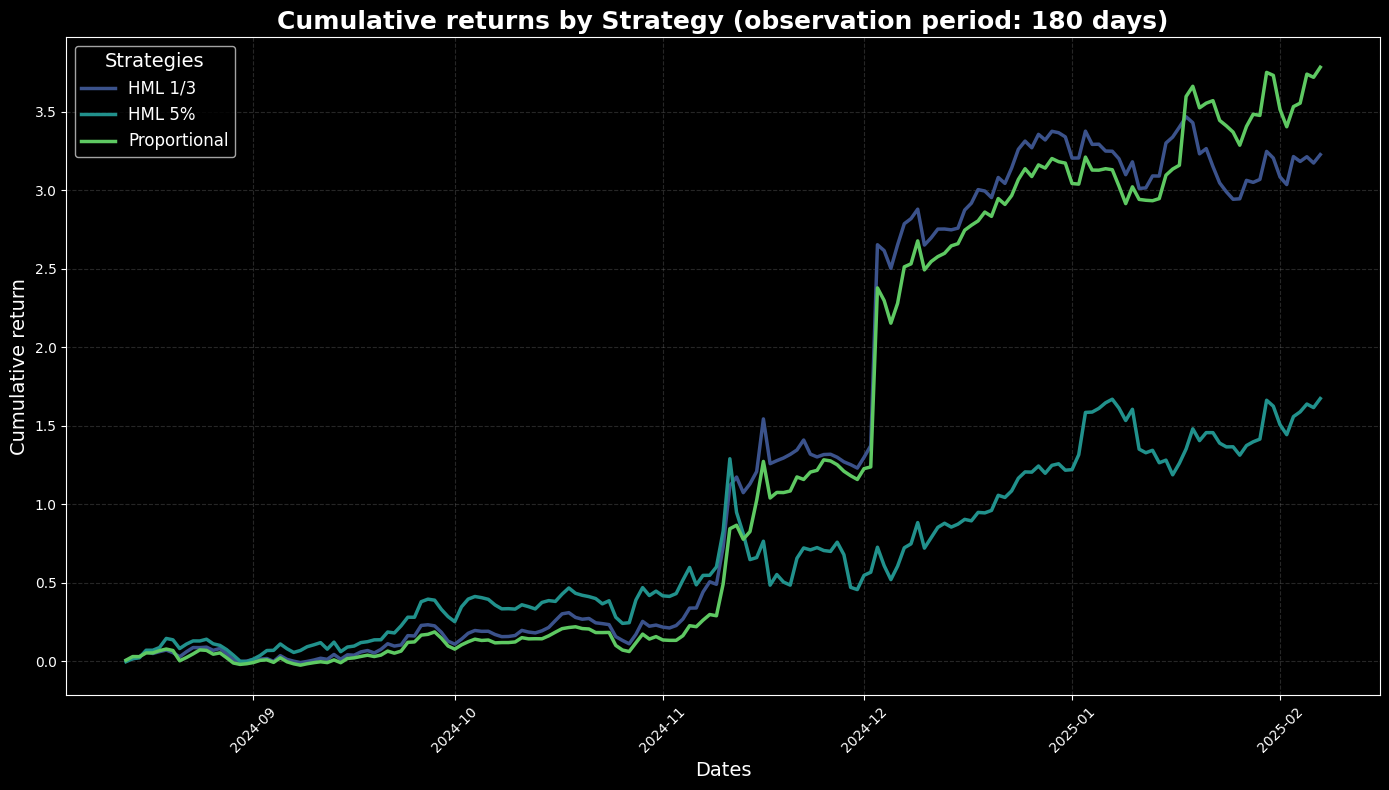

In [59]:
# Tracé des rendements cumulés
plot_cumulative_returns(results, dates) 

In [ ]:

# Définir le chemin de base du projet (adapté pour un Jupyter Notebook)
BASE_DIR = Path.cwd().parent  # Remonte d'un niveau depuis le notebook

#  Répertoires des données
DATA_DIR = BASE_DIR / "data"
RAW_DATA_DIR = DATA_DIR / "raw"

#  Fichiers CSV et JSON
CRYPTO_NEWS_CLEANED = RAW_DATA_DIR / "crypto_news_cleaned.csv"
CRYPTO_NEWS_SENTIMENTS = RAW_DATA_DIR / "crypto_news_sentiments.csv"
GRAPH_CUMULATIVE_RETURNS = RAW_DATA_DIR / "cumulative_returns.png"



In [61]:
df_crypto.to_csv(CRYPTO_NEWS_CLEANED, index=False)

In [62]:
df_daily.to_csv(CRYPTO_NEWS_SENTIMENTS, index=False)

In [63]:
plot_cumulative_returns(results, dates, save_path=GRAPH_CUMULATIVE_RETURNS)


✅ Graphique sauvegardé avec succès : c:\Users\kadas\Desktop\Mes_cours\FINANCE_QUAN\Projet_finance_quantitative\data\raw\cumulative_returns.png
